In [11]:
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import numpy as np

In [113]:
def coarsen(da: xr.DataArray, factor: int = 10, reduction: str = 'mean') -> xr.DataArray:
    return getattr(da.coarsen(x=factor, y=factor, boundary='trim'), reduction)().compute()

In [163]:
np.array([0])

array([0])

In [164]:
class RSData(Dataset):
    def __init__(self, ds_path: str, mask_area: list[int] | int, cutout_size: int = 21):
        super().__init__()

        self.ds = xr.open_zarr(ds_path)

        if cutout_size % 2 == 0:
            raise ValueError('`cutout_size` must be an odd integer.')

        self.mask_values = self.get_mask_values(mask_area)

        self.cutout_size = cutout_size

        self.mask = self.ds.mask.isin(self.mask_values).compute()

        self.coords = np.argwhere(self.mask.values)
        
    def get_mask_values(self, mask_area: list[int] | int) -> np.ndarray:
        mask_area_ = np.array([mask_area] if isinstance(mask_area, int) else mask_area)

        if any(mask_area_ < 0) or any(mask_area_ > 4):
            raise ValueError('`mask_values` must be in range [0, ..., 4]')

        mask_values = np.argwhere(np.isin((np.arange(1, 13) - 1) % 4, mask_area_ - 1)).flatten() + 1

        if any(mask_area_ == 0):
            mask_values = np.concatenate((mask_values, np.zeros(1, dtype=int)))

        return mask_values

    def __len__(self) -> int:
        return len(self.coords)

    def __getitem__(self, index: int):
        x_i, y_i = self.coords[index]

        offset = int(self.cutout_size // 2)

        x_sel = self.ds.rs.isel(
            x=slice(x_i - offset, x_i + offset + 1),
            y=slice(y_i - offset, y_i + offset + 1),
        )
        label_sel = self.ds.label.isel(
            x=x_i,
            y=y_i,
        )

        return x_sel.values.astype('float32'), label_sel.values.astype('int')


In [171]:
rsdata = RSData('../data/combined.zarr', mask_area=[1, 4], cutout_size=21)

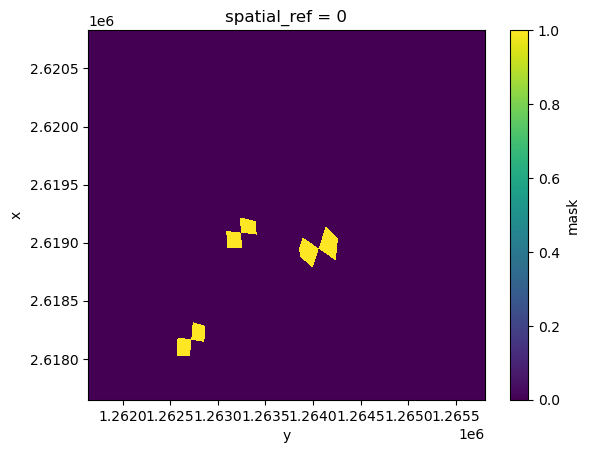

In [172]:
coarsen(rsdata.mask, reduction='max').plot()